# Langfun Template: A Canvas for Painting LLM Context


Communicating with LLM is like painting a picture, with elements of different sources and modalities putting together. Langfun provides `lf.Template` as a canvas for enabling free expression of complex context through a drop-and-play manner. Basically, users could drop anything into a template (e.g., images, python objects, LLM responses, even template objects themselves) to paint the context for the LLM. This notebook illustrates how to use `lf.Template` from the simplest to more complex use cases.

- [Getting Started](#scrollTo=ZWG2OviO5uwP)
- [Dropping In Anything](#scrollTo=tHdocYHBD2kl)
- [Template Composition](#scrollTo=_qJfpinSc9PF)
- [Advanced: Complex Composition](#scrollTo=zRRo-n43k7qB)

In [ ]:
import langfun as lf

## Getting Started

### Template and Message

Two concepts are essential to work with prompting LLMs in Langfun: Templates (represented by `lf.Template`) and messages (`lf.Message`). While message is the communication protocol with LLMs in Langfun, template is a factory that generates messages. As a factory, Template could generate different messages with different variable bindings.

The following example creates a simple template with variable `name`, which could be bound at creation time or render time.

In [ ]:
template = lf.Template('Hello {{name}}!', name='Langfun')
message = template.render()
print(message)

# Or
print(template.render(name='LLM'))

Hello Langfun!
Hello LLM!


In the example above, `message` looks like a string, but it is an object that can encapsulate both text and multi-modal objects. You can inspect its details by simply displaying it in Colab.

In [ ]:
message

UserMessage(text='Hello Langfun!', sender='User', referred_modalities={}, metadata={__template_input__={name='Langfun'}}, tags=[0: 'rendered'])

Then we could pass `message` to `lf.query` to prompt the LLM:

In [ ]:
lm = lf.llms.VertexAIGemini25Flash(project='langfun')
lf.query(message, lm=lm)

'Hello there! How can I help you today?'

For convenience, `lf.query` allows users to directly pass template objects as the prompt, or even strings with keyword arguments. Therefore these three query examples are equivalent. Underlying, the string or `lf.Template` object will be rendered into `lf.Message` before sending to the LLM.

```python
# Prompting LLM using message.
lf.query(message, lm=lm)

# Prompting LLM directly using template.
lf.query(template, lm=lm)

# Prompting LLM using string and keyword arguments.
lf.query('Hello {{name}}', lm=lm, name='Langfun')
```

### Subclassing Templates

Users could directly use `lf.Template` to create a template or subclass it with better modularities. We have shown how to create a `lf.Template` object above, here is an example of subclassing.

In [ ]:
class HelloPrompt(lf.Template):
  """Prompt for greeting LLMs.

  Hello {{name}}
  """
  name: str

print(HelloPrompt(name='Langfun').render())

Hello Langfun


As you can see, the template body is defined in the doc-string of the class, with a few caveats:

- The short description and the blank line after it is not part of the template body. It allows developers to describe the purpose of the class.
- If you do not want Langfun to treat a doc string as template body, you could embed **'THIS IS NOT A TEMPLATE'** in the doc string. This is usually useful when you inherit a template body from a parent class and you don't want to change it, while you want to document the subclass in details. E.g.

```python
class MyHelloPrompt(HelloPrompt):
  """A customization of HelloPrompt.

  This prompt provides the default value for `name`, so users don't have to
  set name everytime.

  (THIS IS NOT A TEMPLATE)
  """
  name = 'Langfun'

MyHelloPrompt().render()
```


Besides modularity, subclassing `lf.Template` allows developers to embed complex logics through properties and methods. For example:

In [ ]:
class PromptWithComputedFields(lf.Template):
  """An illustration of template with computed fields.

  Hello {{name}} {{len}}
  """
  name: str

  @property
  def len(self):
    return len(self.name)

print(PromptWithComputedFields(name='Langfun').render())

Hello Langfun 7


## Dropping In Anything

`lf.Template` employes an intuitive way for painting your canvas for prompting LLMs - **You simply drop the objects into the template, that's it!**
These objects could be multi-modal objects such as images, audios, videos and PDFs, they could also be Python objects. Moreover, you could drop `Message` and `Template` objects into it for composition.

In [ ]:
import pyglove as pg

class Ant(pg.Object):
  pass

message = lf.Template(
    """
    Here are two animals: {{animal1}} and {{animal2}}, which has bigger size?
    """,
    animal1=lf.Image.from_uri(
        'https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/African_Bush_Elephant.jpg/1200px-African_Bush_Elephant.jpg'
    ),
    animal2=Ant()
).render()
message

UserMessage(text='Here are two animals: <<[[image:d3fd4e72]]>> and `Ant()`, which has bigger size?', sender='User', referred_modalities={image:d3fd4e72=Ref(Image(uri='https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/African_Bush_Elephant.jpg/1200px-African_Bush_Elephant.jpg', content=None))}, metadata={__template_input__={animal1=Ref(Image(uri='https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/African_Bush_Elephant.jpg/1200px-African_Bush_Elephant.jpg', content=None)), animal2=Ref(Ant())}}, tags=[0: 'rendered'])

In [ ]:
# See how LLM is able to reason about them.
lf.query(message, lm=lm)

'Among an elephant and an ant, the **elephant** has a significantly bigger size.'

## Template Composition

Langfun enables template composition by allowing one template or message to be embedded within another. This flexibility lets users directly incorporate LLM and tool responses into templates to form prompts for subsequent turns in agent development. For example:

In [ ]:
from typing import Any

class MetaPrompt(lf.Template):
  """A prompt for adding high level instructions.

  {{instruction}}
  {{problem}}
  """
  instruction: str
  problem: Any

maze_image = lf.Image.from_uri(
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRU4IUa-8X9ekli8iUBiDQAvA_g-jsc5YjnGQ&s'
)

message = MetaPrompt(
    instruction='Think step by step',
    problem=lf.Template(
        'What is the meaning of {{concept}}?',
        concept=lf.Template('shapes in {{image}}', image=maze_image)
    )
).render()
message

UserMessage(text='Think step by step\nWhat is the meaning of shapes in <<[[image:a9ec8c38]]>>?', sender='User', referred_modalities={image:a9ec8c38=Ref(Image(uri='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRU4IUa-8X9ekli8iUBiDQAvA_g-jsc5YjnGQ&s', content=None))}, metadata={__template_input__={problem=Ref(Template(template_str='What is the meaning of {{concept}}?', clean=True, concept=Template(template_str='shapes in {{image}}', clean=True, image=Image(uri='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRU4IUa-8X9ekli8iUBiDQAvA_g-jsc5YjnGQ&s', content=None)))), instruction='Think step by step'}}, tags=[0: 'rendered'])

Here is how the LLM responds to it:

In [ ]:
lf.query(message, lm=lm)

"The image you sent shows a square maze. Here's a breakdown of the meaning of the shapes within it:\n\n*   **The Outer Square:** This defines the boundary of the maze. It tells you where the puzzle begins and ends, and that your path must stay within these limits.\n*   **The Black Lines/Walls:** These are the most crucial shapes. They represent obstacles or barriers. Your goal is to navigate *around* these walls, not through them, to find a continuous path from the start to the end.\n*   **The White Spaces/Paths:** These are the navigable areas of the maze. They are the corridors and turns you can move through. The objective is to find the correct sequence of these white spaces that leads to the exit.\n*   **The Red Arrows:** These are indicators.\n    *   The **left arrow** points to the entrance of the maze. This is where you should begin your journey.\n    *   The **right arrow** points to the exit of the maze. This is your destination.\n\nIn essence, the shapes together create a pr

We could ask Gemini to solve this maze by generating an image with solution:

AIMessage(text="Absolutely! Here's the solution to the maze: <<[[image:377e7bf4]]>>", sender='AI', referred_modalities={image:377e7bf4=Ref(Image(uri=None, content=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00\x00\x00\x04\x00\x08\x02\x00\x00\x00\xf0\x7f\xbc\xd4\x00\x00\x00\x89zTXtRaw profile type iptc\x00\x00\x08\x99M\x8c1\x0e\x021\x0c\x04\xfb\xbc\xe2\x9e\x908\xeb\xb5]S\xd1Q\xf0\x81\xbb\\"!!\x81\xf8\x7fA\xa0\xe0\x98iV[L:_\xae\xa7\xe5\xf9z\x8c\xdb\xbd\xa7\xe5\x0b\x91\xaaC\x10\xd83\xa6?\x8a\x97\x96\x85}\xae\x8a\x9d\x85\xa0J6c\x18\xe8\x92a\x1cSc\xfb\xfc(\x88\xa3#\xfa\xd7\xc9\xcd\xb7\xeaA\xdd\x00\xad\xb6F\xf1\xd5\xbai\x847\xefu0\xbd\x01C\xeb"\xa2\xee\xfdZc\x00\x00\x02\x87iTXtXML:com.adobe.xmp\x00\x00\x00\x00\x00<?xpacket begin="\xef\xbb\xbf" id="W5M0MpCehiHzreSzNTczkc9d"?> <x:xmpmeta xmlns:x="adobe:ns:meta/" x:xmptk="XMP Core 5.5.0"> <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"> <rdf:Description rdf:about="" xmlns:Iptc4xmpExt="http://iptc.org/std/Iptc4xmpExt/2008-02-29/" xmlns:photoshop="http://ns.adobe.com/photoshop/1.0/" Iptc4xmpExt:DigitalSourceFileType="http://cv.iptc.org/newscodes/digitalsourcetype/trainedAlgorithmicMedia" Iptc4xmpExt:DigitalSourceType="http://cv.iptc.org/newscodes/digitalsourcetype/trainedAlgorithmicMedia" photoshop:Credit="Made with Google AI"/> </rdf:RDF> </x:xmpmeta>   <?xpacket end="w"?>\x7f\x12hk\x00\x00 \x00IDATx\x9c\xec}\xe9\x82\xe4(\xae\xae\x14\xf7\xbc\xff\x1bw\xe8\xfe\x00I\x9f\x160\x8e%+\xab\xa7\x99\x9e\xac0\x06mhc\xb1\xcd\xcf\x7f\x9e\xfc`!b"\x12!&"\x16\x9a\x85I\xf02\x16a"\xb1\x86\xf1V\xbc\x1c\r\x99HH\x88\x98\xb5\x8d\x02\x98\xe8\x99\xa4C\xc5Z\xcf\t\xb0^\x1b\xf8\tj\\\x8b\x92\x9f\xeacy\x121\x11+a\x15\x7f!v\xd2?d\x85\xed\xd9\x18\xc4\xfa\xd1\x0c\xe5c2{\xf4\xfc\x1e\x96\x8e\x1b\xa3D\xc4P\x9a\x08H\x98I\x86P\xc4\xd8"\xe2Y\xcfD",\xcf\xd9\x92xj\xc3l\xe8J!\x8a\x9f\x88\x06\x0b\xc2\xa3\x92\x99\x88I\xd8\xdb\xf3\x93x\xc0\x9e\xf0\xe9\xa9\x10"\x1c\x1b\xb2\xa6\xbe\xc3\x8b|5\x8d\t\xe8\x0f\xfc\x8a\xb6\x1d|\xa9\x86\xb30\x8b\x101\xb1\xc8\x83\x84\xe4I\xccB\xfc\xe4\xc7S\xe8\xc1\xc4B\x0f\x16z\xfeC\x0f&\xe1\'?\x86\n0\x11\x8f\xfa!4~<\x85\x98\x89E\xe5\xc0,B2\xda\x8fz\x16z\xfe#\xfc\x10b"mO\xf4\xe0\'=\x9f\x05\xce`!\xc9\x8dU\x9eBD\x826\xab\xf5\xa3\x92\xad\xfdd\xb6\x1fw5gvy2\xb1\xccA\x19\xf2\x19r \x19t\xfeC\x8f\x07\t\x0b?\xfe\x19\xf5D\x0f\x12z>\xe91$\xf9P\xab\x1d\xfc>\xe9\xf1\x18\xf5\x83\xaf\xd9~\xe8\x1b11?\x87\xda\x111=\xc9\xf8r\xb9\x11\x0f\xf9<Xd\xcaG\xe9\x11y\xfe\xc3\xfc@Q\x04\x95\x18\x83\x8br\x90\xa70\x0b1\xc1\xf8\xb2\xca\x1f\xf1*\xbf:.\xf4x\xaa\xad3\x0f{\xb1qi\xf4m\xa5\xb72\x87\xca\x84,c\xa4Z~I\xa2>\xf0\x93\xc4\xf5J\xe9\x9fzE\x8f\xff\x17\xe4\xdc\xd0\xa9\x86-@\'\xf3\xb8b&\x92\xa7{~a\x19\xca0\x1d\x8e\xb9\xfd\x01-\xb8\xb6Q)\xc4\xa0\xff\xd3\xc3N?\xc0\xaa\x12\xf24#\x15\x95\x83\xfa\x8d\x811\xf2\xfb|\xd2\xe3A\x93_af~\x0e9L\xbdr\xb9\x11\xb1<\xdd\xffX\xfds\xe8\x95\x8f\xef\x94\xdb\xd07\x95\xf33\xc9\xff\x9f\'=\x1ec\\\xaa\xfe\'=d\x16\x9e\xf5u\\\xa6\xde\x92\xd9K\x07\x87\xa7\x9fy\xd2S#\xd3\x03\xe50\xece\ny\xca\xd9\xf9\xd5\xf1e\xd6\x91\x959H\x0f\x1e\xa1\x89xxj\x18_\xb3;.p\xd4^:\xff\xc9\xe8\xe7Q\x9ef/\xf2`\x12\x8c#\xe26\xb1L\x18\xd8P<X\xdc\xff0\x91\xf0\x93\x88y\x18\xad\xea\x7fo/\x0f\x12z6v1\xe5\xfc\xcf\x93\xfe\xdf\x83\xe8\xf9\x9c\xfe\xfc\xff\xfd?\x01?\xe6~^\x83\xe0\xd3\xe3\xd7\x93D\x86\x08\xc5\xe2\x1a\x99<g\xe5\x90\xdb#\xf8\xd5\xd6\x0f\x90\xbb\x02\x8f\xb3.\x07\x82\xfa\x08\x9f\x89\xe8A&\x07R\xfb"\r\xc1\xcf1\xf4\xda\x98\xa7^x\xbc#\x84S\xe8\x9f\xe3\xf5\xc0\xf1\x85|\x80c{s\'\xea\xc7\x8c_\xd6\xf0c\xf4#km\xbeu\xa3HV#1\xd1a\xfd\xcc\x1f\xd9\x92@"\x11K\xe2\xc8\xf2\xa2\x10O\x95\xfe\xd9CF\x83\x19D\x98\xa7\xf6I!\x81H1\x19F\xa2\x91\xd9\xa64\x15\x9b[\xea\x8bI]M\xf0x\xc2\x11R\x03g\x1b\x87\nD\xfd\xb3\xe5\xa5\x90\xcb\xca\xa8\x97\'?\x87C\xd1\xd4\xc4\xc2R\x10\xf2\xb8mB|e\xd8\x1an\x8a\x18\xf6`k{\xa20,\xa3zH\xe4\x99\xb5+7S`\xc3\xb3\xf1\x13`\x1eR~I\x8f\xe3 z\x10\x13\xd4?\xb5\xfd\xa6\x17\xfe\xb0\x12\xddBS\x8f\xe4\xd1\xd4\x0c\xa9]*\xe5\xb3\x9eID\xc8=\x9b\x8d\xb8\x93\x135\xc1L(\x00\x8a\xf0\x9d\x06\x81q\x88\xf4\x0c\xf9\x8c\xb0\xb2\xa13h`\x1
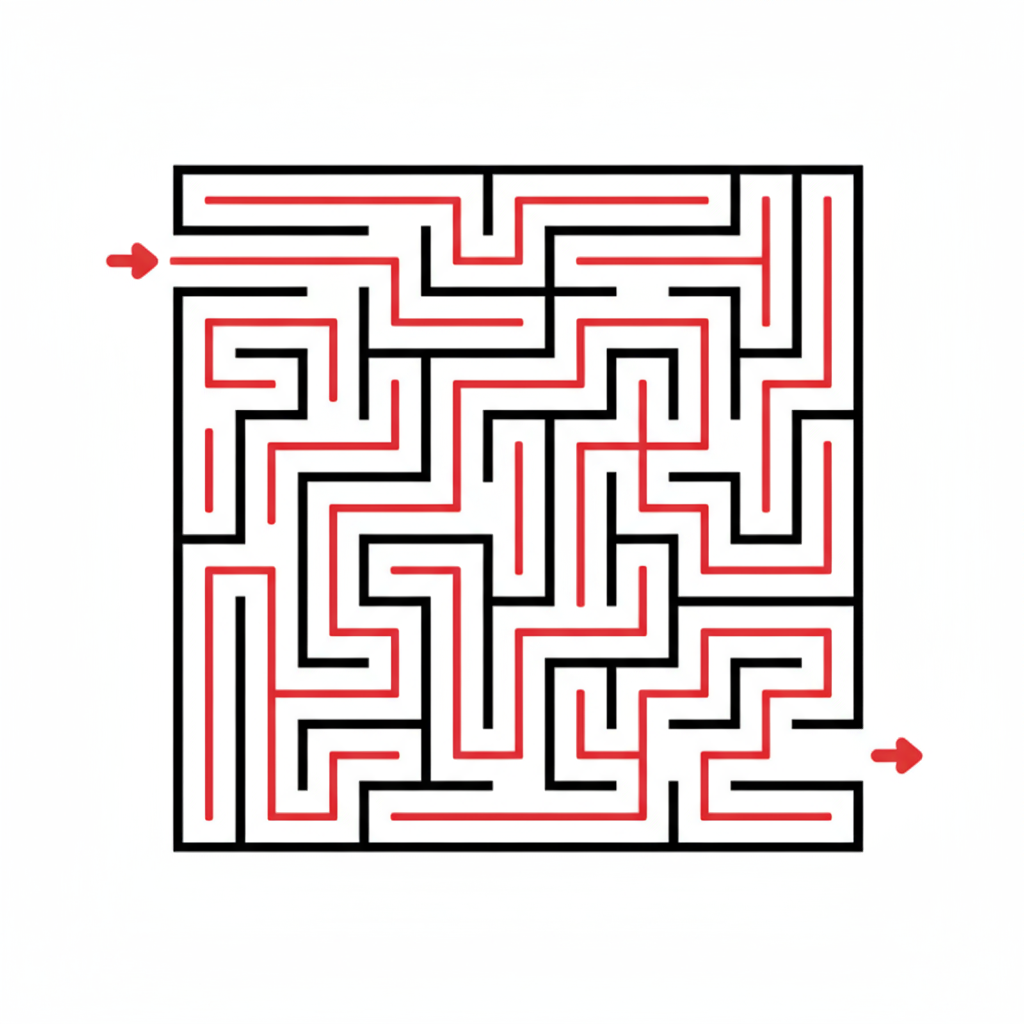
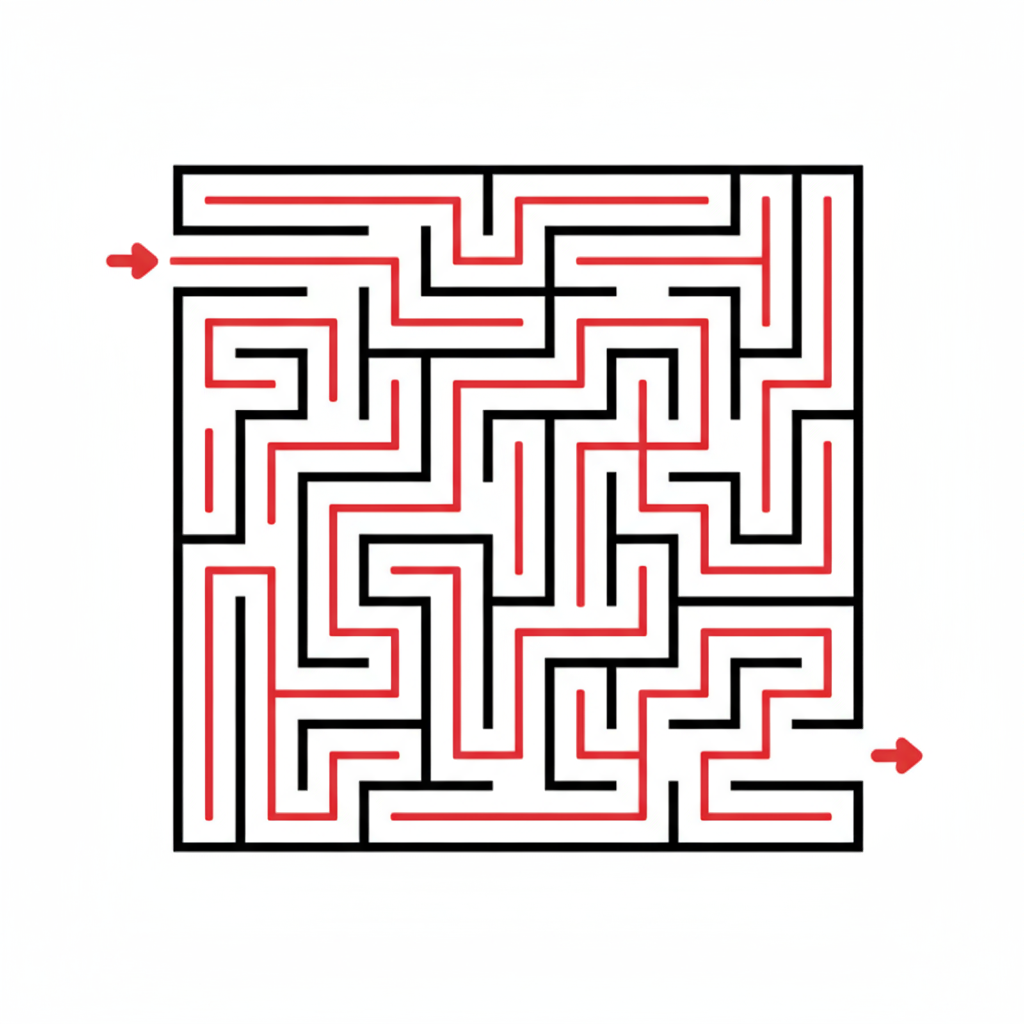

In [ ]:
lm = lf.llms.VertexAIGemini25FlashImagePreview(project='langfun')
response = lf.query('Solve {{maze}}', lm=lm, maze=maze_image)
response

You can show the generated image with:

Image(uri=None, content=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00\x00\x00\x04\x00\x08\x02\x00\x00\x00\xf0\x7f\xbc\xd4\x00\x00\x00\x89zTXtRaw profile type iptc\x00\x00\x08\x99M\x8c1\x0e\x021\x0c\x04\xfb\xbc\xe2\x9e\x908\xeb\xb5]S\xd1Q\xf0\x81\xbb\\"!!\x81\xf8\x7fA\xa0\xe0\x98iV[L:_\xae\xa7\xe5\xf9z\x8c\xdb\xbd\xa7\xe5\x0b\x91\xaaC\x10\xd83\xa6?\x8a\x97\x96\x85}\xae\x8a\x9d\x85\xa0J6c\x18\xe8\x92a\x1cSc\xfb\xfc(\x88\xa3#\xfa\xd7\xc9\xcd\xb7\xeaA\xdd\x00\xad\xb6F\xf1\xd5\xbai\x847\xefu0\xbd\x01C\xeb"\xa2\xee\xfdZc\x00\x00\x02\x87iTXtXML:com.adobe.xmp\x00\x00\x00\x00\x00<?xpacket begin="\xef\xbb\xbf" id="W5M0MpCehiHzreSzNTczkc9d"?> <x:xmpmeta xmlns:x="adobe:ns:meta/" x:xmptk="XMP Core 5.5.0"> <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"> <rdf:Description rdf:about="" xmlns:Iptc4xmpExt="http://iptc.org/std/Iptc4xmpExt/2008-02-29/" xmlns:photoshop="http://ns.adobe.com/photoshop/1.0/" Iptc4xmpExt:DigitalSourceFileType="http://cv.iptc.org/newscodes/digitalsourcetype/trainedAlgorithmicMedia" Iptc4xmpExt:DigitalSourceType="http://cv.iptc.org/newscodes/digitalsourcetype/trainedAlgorithmicMedia" photoshop:Credit="Made with Google AI"/> </rdf:RDF> </x:xmpmeta>   <?xpacket end="w"?>\x7f\x12hk\x00\x00 \x00IDATx\x9c\xec}\xe9\x82\xe4(\xae\xae\x14\xf7\xbc\xff\x1bw\xe8\xfe\x00I\x9f\x160\x8e%+\xab\xa7\x99\x9e\xac0\x06mhc\xb1\xcd\xcf\x7f\x9e\xfc`!b"\x12!&"\x16\x9a\x85I\xf02\x16a"\xb1\x86\xf1V\xbc\x1c\r\x99HH\x88\x98\xb5\x8d\x02\x98\xe8\x99\xa4C\xc5Z\xcf\t\xb0^\x1b\xf8\tj\\\x8b\x92\x9f\xeacy\x121\x11+a\x15\x7f!v\xd2?d\x85\xed\xd9\x18\xc4\xfa\xd1\x0c\xe5c2{\xf4\xfc\x1e\x96\x8e\x1b\xa3D\xc4P\x9a\x08H\x98I\x86P\xc4\xd8"\xe2Y\xcfD",\xcf\xd9\x92xj\xc3l\xe8J!\x8a\x9f\x88\x06\x0b\xc2\xa3\x92\x99\x88I\xd8\xdb\xf3\x93x\xc0\x9e\xf0\xe9\xa9\x10"\x1c\x1b\xb2\xa6\xbe\xc3\x8b|5\x8d\t\xe8\x0f\xfc\x8a\xb6\x1d|\xa9\x86\xb30\x8b\x101\xb1\xc8\x83\x84\xe4I\xccB\xfc\xe4\xc7S\xe8\xc1\xc4B\x0f\x16z\xfeC\x0f&\xe1\'?\x86\n0\x11\x8f\xfa!4~<\x85\x98\x89E\xe5\xc0,B2\xda\x8fz\x16z\xfe#\xfc\x10b"mO\xf4\xe0\'=\x9f\x05\xce`!\xc9\x8dU\x9eBD\x826\xab\xf5\xa3\x92\xad\xfdd\xb6\x1fw5gvy2\xb1\xccA\x19\xf2\x19r \x19t\xfeC\x8f\x07\t\x0b?\xfe\x19\xf5D\x0f\x12z>\xe91$\xf9P\xab\x1d\xfc>\xe9\xf1\x18\xf5\x83\xaf\xd9~\xe8\x1b11?\x87\xda\x111=\xc9\xf8r\xb9\x11\x0f\xf9<Xd\xcaG\xe9\x11y\xfe\xc3\xfc@Q\x04\x95\x18\x83\x8br\x90\xa70\x0b1\xc1\xf8\xb2\xca\x1f\xf1*\xbf:.\xf4x\xaa\xad3\x0f{\xb1qi\xf4m\xa5\xb72\x87\xca\x84,c\xa4Z~I\xa2>\xf0\x93\xc4\xf5J\xe9\x9fzE\x8f\xff\x17\xe4\xdc\xd0\xa9\x86-@\'\xf3\xb8b&\x92\xa7{~a\x19\xca0\x1d\x8e\xb9\xfd\x01-\xb8\xb6Q)\xc4\xa0\xff\xd3\xc3N?\xc0\xaa\x12\xf24#\x15\x95\x83\xfa\x8d\x811\xf2\xfb|\xd2\xe3A\x93_af~\x0e9L\xbdr\xb9\x11\xb1<\xdd\xffX\xfds\xe8\x95\x8f\xef\x94\xdb\xd07\x95\xf33\xc9\xff\x9f\'=\x1ec\\\xaa\xfe\'=d\x16\x9e\xf5u\\\xa6\xde\x92\xd9K\x07\x87\xa7\x9fy\xd2S#\xd3\x03\xe50\xece\ny\xca\xd9\xf9\xd5\xf1e\xd6\x91\x959H\x0f\x1e\xa1\x89xxj\x18_\xb3;.p\xd4^:\xff\xc9\xe8\xe7Q\x9ef/\xf2`\x12\x8c#\xe26\xb1L\x18\xd8P<X\xdc\xff0\x91\xf0\x93\x88y\x18\xad\xea\x7fo/\x0f\x12z6v1\xe5\xfc\xcf\x93\xfe\xdf\x83\xe8\xf9\x9c\xfe\xfc\xff\xfd?\x01?\xe6~^\x83\xe0\xd3\xe3\xd7\x93D\x86\x08\xc5\xe2\x1a\x99<g\xe5\x90\xdb#\xf8\xd5\xd6\x0f\x90\xbb\x02\x8f\xb3.\x07\x82\xfa\x08\x9f\x89\xe8A&\x07R\xfb"\r\xc1\xcf1\xf4\xda\x98\xa7^x\xbc#\x84S\xe8\x9f\xe3\xf5\xc0\xf1\x85|\x80c{s\'\xea\xc7\x8c_\xd6\xf0c\xf4#km\xbeu\xa3HV#1\xd1a\xfd\xcc\x1f\xd9\x92@"\x11K\xe2\xc8\xf2\xa2\x10O\x95\xfe\xd9CF\x83\x19D\x98\xa7\xf6I!\x81H1\x19F\xa2\x91\xd9\xa64\x15\x9b[\xea\x8bI]M\xf0x\xc2\x11R\x03g\x1b\x87\nD\xfd\xb3\xe5\xa5\x90\xcb\xca\xa8\x97\'?\x87C\xd1\xd4\xc4\xc2R\x10\xf2\xb8mB|e\xd8\x1an\x8a\x18\xf6`k{\xa20,\xa3zH\xe4\x99\xb5+7S`\xc3\xb3\xf1\x13`\x1eR~I\x8f\xe3 z\x10\x13\xd4?\xb5\xfd\xa6\x17\xfe\xb0\x12\xddBS\x8f\xe4\xd1\xd4\x0c\xa9]*\xe5\xb3\x9eID\xc8=\x9b\x8d\xb8\x93\x135\xc1L(\x00\x8a\xf0\x9d\x06\x81q\x88\xf4\x0c\xf9\x8c\xb0\xb2\xa13h`\x1d\xaf%_K~\xdd\xe2\xd1\x17\x0bx\r~\xb2:\x83\xc1\xa8(\xc5c$\xc9b\xee\x02\xbe\xd6\x83\xb7\x10fz*\xfc\t\x8e\x1d\xbe\x148w\xc7\x11\xee\x81=\x8fH
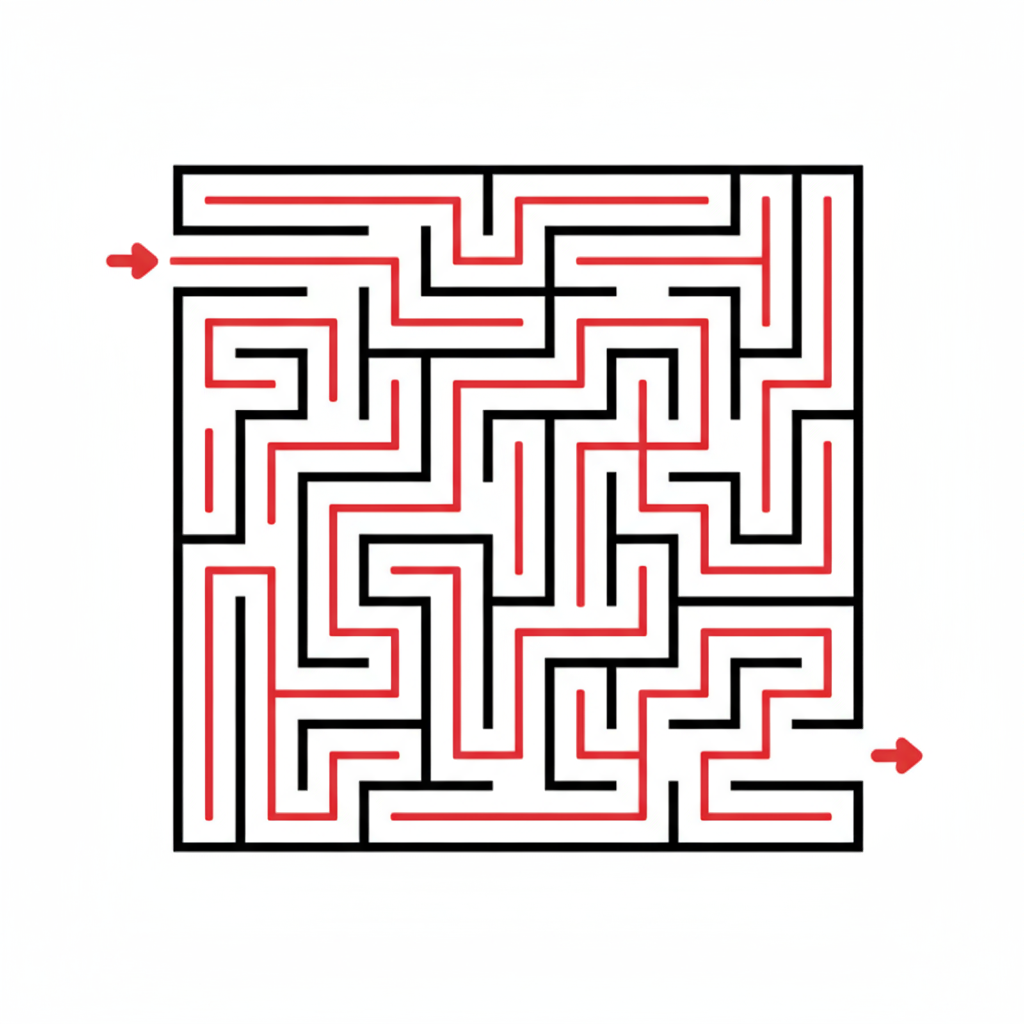

In [ ]:
response.images[0]

We can further ask the LLM if this solution is correct by dropping the response directly into the verifier prompt (though the answer is not quite right):

In [ ]:
class MazeVerifier(lf.Template):
  """Prompt for verifing the solution of a maze.

  Is the solution to a maze correct?
  Please check
  1) The line should start from the starting point and end at the ending point.
  2) The line should be continuous and does not branch.
  3) The line should not cross the black lines (walls)

  {{solution}}

  """
  solution: Any

lf.query(
    MazeVerifier(solution=response),
    lm=lf.llms.VertexAIGemini25Pro(project='langfun')
)

"Based on the rules you provided, let's check the maze solution:\n\n1.  **Starts and Ends Correctly:** Yes, the red line begins at the starting arrow on the left and finishes at the ending arrow on the right.\n2.  **Continuous and No Branching:** Yes, the red line is a single, continuous path from start to finish without any splits or branches.\n3.  **Does Not Cross Walls:** Yes, the red line stays within the open passages and does not cross any of the black walls.\n\n**Conclusion:** The solution to the maze is **correct**. It successfully follows all the rules."

## Advanced: Complex Composition With Template Language

Langfun templates go beyond simple variable embedding. They offer a powerful language for expressing conditions, loops, and precise format control, leveraging the capabilities of [Jinja2](https://jinja.palletsprojects.com/en/stable/templates/). As a result, it enables complex compositional use cases. The following example shows how to include few-shot exemplars during prompting.

In [ ]:
class FewshotPrompt(lf.Template):
  """Fewshot prompt.

  {%- if exemplars %}
  {% for e in exemplars %}
  Example {{loop.index + 1}}:
  {{e}}
  {% endfor %}
  {% endif -%}
  Prompt: {{prompt}}
  """
  prompt: str
  exemplars: list[Any] = []

class Exemplar(lf.Template):
  """An exemplar.

  Prompt: {{prompt}}
  Response: {{response}}
  """
  prompt: str
  response: str

FewshotPrompt(
    prompt="Who is the president of the United States?",
    exemplars=[
        Exemplar(prompt="1 + 2", response="3"),
        Exemplar(prompt="What is the capital of Germany?", response="Berlin"),
    ]
).render()

UserMessage(text='Example 2:\nPrompt: 1 + 2\nResponse: 3\n\nExample 3:\nPrompt: What is the capital of Germany?\nResponse: Berlin\n\nPrompt: Who is the president of the United States?', sender='User', referred_modalities={}, metadata={__template_input__={exemplars=Ref([0: Exemplar(template_str='Prompt: {{prompt}}\nResponse: {{response}}', clean=True, prompt='1 + 2', response='3'), 1: Exemplar(template_str='Prompt: {{prompt}}\nResponse: {{response}}', clean=True, prompt='What is the capital of Germany?', response='Berlin')]), prompt='Who is the president of the United States?'}}, tags=[0: 'rendered'])